`This notebook summarizes the results in Secrest et al. (2020)`<a href="https://arxiv.org/abs/2009.14826">`[2009.14826]`</a>

***

In [1]:
import numpy as np
import healpy as hp
import scipy.constants as sc

from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.coordinates import Galactic
from astropy import units as u

import matplotlib.pyplot as plt
from matplotlib import rcParams as rcp
from matplotlib.legend_handler import HandlerTuple
from pylab import arange, show, cm
%matplotlib inline

from helperfunctions import *
from dipolefunctions_CatWISE import *

from time import time

rcp['text.usetex'] = True
rcp['font.family'] = 'serif'
rcp['font.serif']='Times New Roman'
rcp['font.size'] = 20.0

rcp['axes.formatter.useoffset'] = False
rcp['axes.linewidth'] = 1.5
rcp['axes.axisbelow'] = False
rcp['xtick.major.width'] = 2
rcp['xtick.minor.width'] = 2
rcp['xtick.major.size'] = 8
rcp['xtick.minor.size'] = 4
rcp['xtick.labelsize'] = 20
rcp['xtick.direction'] = 'in'
rcp['ytick.major.width'] = 2
rcp['ytick.minor.width'] = 2
rcp['ytick.major.size'] = 8
rcp['ytick.minor.size'] = 4
rcp['ytick.labelsize'] = 20
rcp['ytick.direction'] = 'in'

rcp['legend.fontsize'] = 20

rcp['agg.path.chunksize'] = 10000
rcp['image.cmap'] = 'viridis'

rcp['contour.negative_linestyle'] = 'solid'

***

In [2]:
def getFluxAndAlpha(cat) :
    
    flux = cat['k']*cat['nu_W1_iso']**cat['alpha_W1']
    alpha = -cat['alpha_W1']
    
    return flux,alpha

# Load CatWISE catalog

In [3]:
catwiseAGNs_extended = fits.open('../Data/catwise_agns_masked_final_w1lt16p5_alpha.fits')[1].data

flux_w1_extended, alpha_w1_extended = getFluxAndAlpha(catwiseAGNs_extended)

`catwiseAGNs_extended` is a sample of the complete CatWISE2020 catalog, where cuts were performed as described in the publication, except for the flux cut that is chosen a bit weaker here, $W1<16.5$ instead of $W1<16.4$ (hence `_extended`).  We perform the final cut in the next cell.

In [4]:
W1_fluxcut = 8.52707e-28 # corresponds to W1<16.4

selected = (flux_w1_extended>W1_fluxcut)
catwiseAGNs = catwiseAGNs_extended[selected]

flux_w1, alpha_w1 = getFluxAndAlpha(catwiseAGNs)

print('The maximum magnitude in the W1 band is {:0.4f}'.format(np.max(catwiseAGNs['w1'])))

The maximum magnitude in the W1 band is 16.4000


Let's look at the size of the final catalog.

In [5]:
print('The extended catalog had {:0.0f} sources'.format(len(catwiseAGNs_extended)))
print('The final catalog has {:0.0f} sources'.format(len(catwiseAGNs)))

The extended catalog had 1604392 sources
The final catalog has 1355352 sources


This is how the source distribution looks on the sky:

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


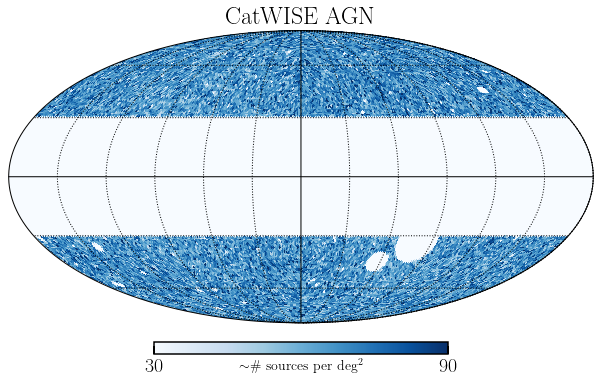

In [6]:
nside = 64

lon,lat = catwiseAGNs['l'],catwiseAGNs['b']
densitymap = scattomap(lon,lat,nside=64)

hp.mollview(densitymap * (60./hp.nside2resol(64, arcmin = True))**2,rot=(0,0,0),title=r'CatWISE AGN',unit=r'$\sim$\# sources per deg$^2$',min=30,xsize=1200,max=90,cmap=cm.Blues)
hp.graticule()

# Load masks

Even though the sample is already masked, we here load the masks to perform one more correction to the data.

In [7]:
masks = fits.open('../Data/MASKS_exclude_master_final.fits')[1].data

In [8]:
def make_galmask(nside=256, planecut=30) :
    
    """
    Computes a Galactic plane mask
    """
    
    mask = np.ones(hp.nside2npix(nside))
    vector = hp.ang2vec(0,90,lonlat=1)
    indices = hp.query_disc(nside,vector,np.deg2rad(90+planecut))
    mask[indices] = 0
    indices = hp.query_disc(nside,vector,np.deg2rad(90-planecut))
    mask[indices] = 1
    
    return mask

def make_eclmask(nside=256, planecut=30) :
    
    """
    Computes a Galactic plane mask in Ecliptic coordinates
    """
    
    mask = np.ones(hp.nside2npix(nside))
    lon,lat = 0,90
    ra,dec = GalactictoEquatorial(lon,lat)
    C = SkyCoord(ra*u.deg, dec*u.deg, frame='icrs')
    E = C.transform_to('barycentricmeanecliptic')
    lonecl,latecl = E.lon.value,E.lat.value
    vector = hp.ang2vec(lonecl,latecl,lonlat=True)
    indices = hp.query_disc(nside,vector,np.deg2rad(90+planecut))
    mask[indices] = 0
    indices = hp.query_disc(nside,vector,np.deg2rad(90-planecut))
    mask[indices] = 1
    
    return mask

def make_supergalmask(nside=256, planecut=10) :
    
    """
    Computes a Supergalactic plane mask
    """
    
    mask = np.ones(hp.nside2npix(nside))
    slon,slat = 0,90
    S = SkyCoord(slon*u.deg, slat*u.deg, frame='supergalactic')
    G = S.transform_to('galactic')
    lon,lat = G.l.value,G.b.value
    vector = hp.ang2vec(lon,lat,lonlat=True)
    indices = hp.query_disc(nside,vector,np.deg2rad(90+planecut))
    mask[indices] = 0
    indices = hp.query_disc(nside,vector,np.deg2rad(90-planecut))
    mask[indices] = 1
    
    return mask

def makeMask(psmasks,nside=256,galcut=0,masking='symmetric',ecliptic=False,nops=False,factor=1.) :
    
    """
    Computes a mask given a file that specifies locations and extent of point sources
    """
    
    mask = np.ones(hp.nside2npix(nside))
    pixels = np.arange(hp.nside2npix(nside))
    mask_lon,mask_lat = hp.pix2ang(nside,pixels,lonlat=True)

    cmasks = psmasks[(psmasks['pa']<=2)*(psmasks['radius']<15)]
    emasks = psmasks[(psmasks['pa']>2)]
    
    if nops :
        cmasks = psmasks[(psmasks['pa']<=2)*(psmasks['radius']>5)]
        emasks = psmasks[(psmasks['pa']>2)*(psmasks['radius']>5)]
        
    cmask_lon,cmask_lat,cmask_rad = *EquatorialtoGalactic(cmasks['ra'],cmasks['dec']),cmasks['radius']
    
    if ecliptic :
        Cmask = SkyCoord(cmasks['ra']*u.deg, cmasks['dec']*u.deg, frame='icrs')
        Emask = Cmask.transform_to('barycentricmeanecliptic')
        cmask_lon,cmask_lat = Emask.lon.value,Emask.lat.value
    
    for lon,lat,radius in zip(cmask_lon,cmask_lat,cmask_rad):
        vector = hp.ang2vec(lon,lat,lonlat=True)
        indices = hp.query_disc(nside,vector,factor*np.deg2rad(radius))
        mask[indices] = 0
        if masking=='symmetric' :
            indices = hp.query_disc(nside,-vector,factor*np.deg2rad(radius))
            mask[indices] = 0
    
    emask_lon,emask_lat,emask_rad,emask_ba,emask_pa = *EquatorialtoGalactic(emasks['ra'],emasks['dec']),emasks['radius'], emasks['ba'], emasks['pa']
    
    if ecliptic :
        Cmask = SkyCoord(emasks['ra']*u.deg, emasks['dec']*u.deg, frame='icrs')
        Emask = Cmask.transform_to('barycentricmeanecliptic')
        emask_lon,emask_lat = Emask.lon.value,Emask.lat.value

    for lon,lat,rad,ba,pa in zip(emask_lon,emask_lat,emask_rad,emask_ba,emask_pa) :
        ell = evaluateEllipse(mask_lon,mask_lat,lon,lat,factor*rad,ba,pa)
        mask[ell] = 0
        if masking=='symmetric' :
            ell = evaluateEllipse(mask_lon,mask_lat,lon+180.,-1.*lat,factor*rad,ba,-1.*pa)
            mask[ell] = 0
    
    if galcut : 
        planemask = make_galmask(nside=nside,planecut=galcut)
        if ecliptic :
            planemask = make_eclmask(nside=nside,planecut=galcut)
    else : planemask = np.ones_like(mask)
    
    return mask*planemask

Make a high-resolution and a low-resolution mask (a downgraded version of the high-resolution mask, were all pixels that are not 1 after downgrading are set to 0).

In [9]:
nside_hi = 1024
nside_lo = 64

hires_mask = makeMask(masks,galcut=30,nside=nside_hi,masking='onesided',factor=1)
lores_mask = hp.ud_grade(hires_mask,nside_out=nside_lo)
lores_mask = lores_mask.copy()
lores_mask[(lores_mask!=1)]=0

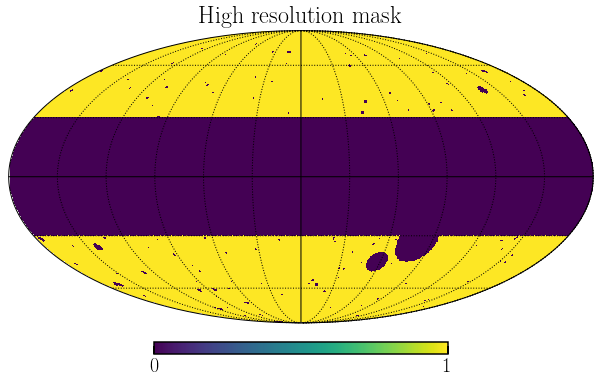

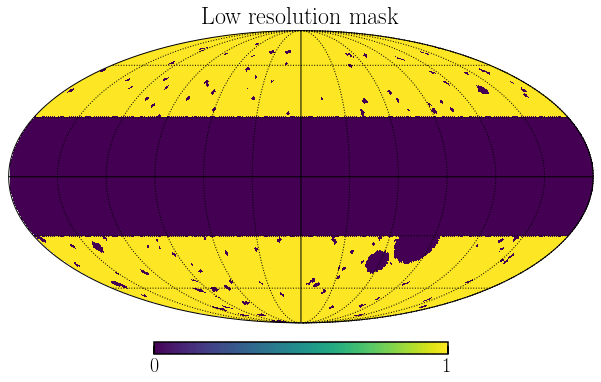

In [10]:
hp.mollview(hires_mask,title='High resolution mask')
hp.graticule(verbose=False)
hp.mollview(lores_mask,title='Low resolution mask')
hp.graticule(verbose=False)

Make an ecliptic-coordinates version of the high-resolution mask

In [11]:
hires_mask_ecl = makeMask(masks,galcut=30,nside=nside_hi,masking='onesided',ecliptic=True)

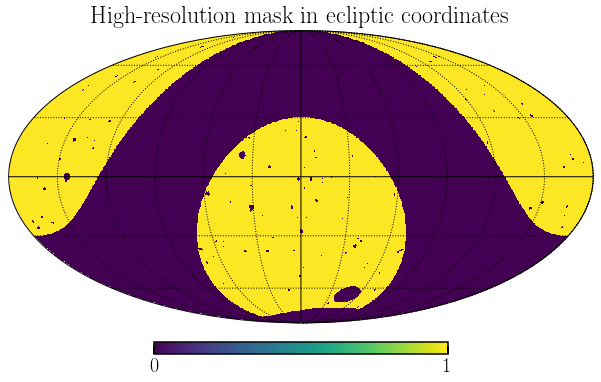

In [12]:
hp.mollview(hires_mask_ecl,title='High-resolution mask in ecliptic coordinates')
hp.graticule(verbose=False)

# Check for ecliptic bias

First transform coordinates of the sources to ecliptic coordinates

In [14]:
ra,dec = GalactictoEquatorial(lon,lat)
C = SkyCoord(ra*u.deg, dec*u.deg, frame='icrs')
E = C.transform_to('barycentricmeanecliptic')
ecl_lon,ecl_lat = E.lon.value,E.lat.value

Now count how many sources are in bins of constant ecliptic latitude (`1` for positive, and `2` for negative latitudes)...

In [15]:
latmap = hp.pix2ang(nside_hi,np.arange(hp.nside2npix(nside_hi)),lonlat=True)[1]

nbins=20

binedges1 = np.linspace(0,90,num=nbins+1)
binedges2 = np.linspace(-90,-0,num=nbins+1)
bincenters1 = binedges1[:-1]+np.diff(binedges1)[0]/2.
bincenters2 = binedges2[:-1]+np.diff(binedges2)[0]/2.
unmasked1 = np.zeros(nbins)
unmasked2 = np.zeros(nbins)
num1 = np.zeros(nbins)
num2 = np.zeros(nbins)

for i in range(nbins) :
    unmasked1[i] = np.sum(hires_mask_ecl[(latmap>binedges1[i])*(latmap<binedges1[i+1])])
    unmasked2[i] = np.sum(hires_mask_ecl[(latmap>binedges2[i])*(latmap<binedges2[i+1])])
    num1[i] = len(ecl_lat[(ecl_lat>binedges1[i])*(ecl_lat<binedges1[i+1])])
    num2[i] = len(ecl_lat[(ecl_lat>binedges2[i])*(ecl_lat<binedges2[i+1])])

...and collect into one vector

In [16]:
bincenters = np.hstack((bincenters1,bincenters2))
unmasked = np.hstack((unmasked1,unmasked2))
num = np.hstack((num1,num2))

select = (unmasked!=0)

bincenters = bincenters[select]
unmasked = unmasked[select]
num = num[select]

Finally, perform linear fit to the latitude profile:

In [17]:
pfit = np.polyfit(np.abs(bincenters),num/unmasked,1,w=1/(1/np.sqrt(num))**1)

print('slope = {:0.4f} 1/deg3'.format(pfit[0]*(60./hp.nside2resol(nside_hi,arcmin=True))**2))
print('offset = {:0.4f} 1/deg2'.format(pfit[1]*(60./hp.nside2resol(nside_hi,arcmin=True))**2))

slope = -0.0513 1/deg3
offset = 68.8913 1/deg2


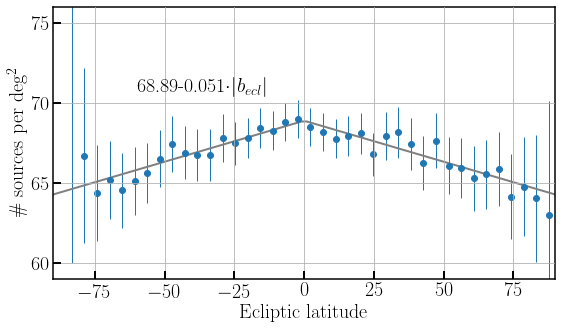

In [18]:
plt.figure(figsize=(9,5),facecolor='w')

plt.errorbar(bincenters,num/unmasked*(60./hp.nside2resol(nside_hi, arcmin = True))**2,yerr=1/np.sqrt(num) * (60./hp.nside2resol(nside_hi, arcmin = True))**2,marker='o',lw=0,elinewidth=1)

elats = np.linspace(-90,90,num=100)
plt.plot(elats,pfit[1]*(60./hp.nside2resol(nside_hi,arcmin=True))**2+pfit[0]*(60./hp.nside2resol(nside_hi,arcmin=True))**2*np.abs(elats),color='gray',lw=2)

plt.text(-60,70.5,'{:.4}-{:.2}'.format(pfit[1]*(60./hp.nside2resol(nside_hi,arcmin=True))**2,-pfit[0]*(60./hp.nside2resol(nside_hi,arcmin=True))**2)+r'$\cdot |b_{ecl}|$',horizontalalignment='left')

plt.grid()

plt.xlabel('Ecliptic latitude')
plt.ylabel(r'\# sources per deg$^2$')

plt.xlim(-90,90)
plt.ylim(59,76);

# Correct for ecliptic bias

We correct for the ecliptic bias by up-weighing the source density in those pixels that are closer to the ecliptic poles, to match the source density at the ecliptic equator.

In [19]:
pixels = np.arange(hp.nside2npix(nside_lo))
plon,plat = hp.pix2ang(nside_lo, pixels, lonlat=True)
gc = SkyCoord(plon * u.deg, plat * u.deg, frame='galactic')
ec = gc.barycentricmeanecliptic
elat = ec.lat.degree

densitymap_eclcor = densitymap*(60./hp.nside2resol(nside_lo,arcmin=True))**2 - pfit[0]*(60./hp.nside2resol(nside_hi,arcmin=True))**2*np.abs(elat)

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


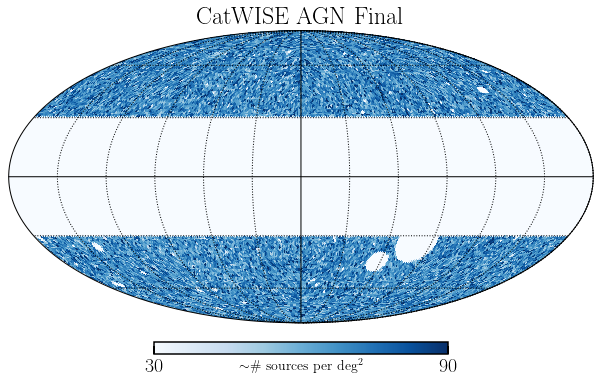

In [20]:
nside = 64

lon,lat = catwiseAGNs['l'],catwiseAGNs['b']
densitymap = scattomap(lon,lat,nside=64)

hp.mollview(densitymap_eclcor,rot=(0,0,0),title=r'CatWISE AGN Final',unit=r'$\sim$\# sources per deg$^2$',min=30,xsize=1200,max=90,cmap=cm.Blues)
hp.graticule()

# Smooth source distribution

In [21]:
def omega_to_theta(omega):
    
    """Convert solid angle omega in steradians to theta in radians for
    a cone section of a sphere."""
    
    return np.arccos(1 - omega / (2 * np.pi)) * u.rad

We smooth the source distribution over 1 radian scales

In [23]:
densitymap_eclcor_smoothed = np.zeros_like(densitymap_eclcor)
zero = np.where(lores_mask==0)[0]
nonzero = np.where(lores_mask==1)[0]
densitymap_eclcor[zero] = np.nan
smoothingradius = np.rad2deg(omega_to_theta(1.).value)

for n,i in enumerate(nonzero) :
    vec = hp.pix2vec(nside_lo,i)
    disc = hp.query_disc(nside_lo,vec,np.deg2rad(smoothingradius))
    densitymap_eclcor_smoothed[i] = np.nanmean(densitymap_eclcor[disc])

densitymap_eclcor_smoothed[(lores_mask==0)]=np.nan

/opt/anaconda3/envs/nbk/lib/python3.7/site-packages/healpy/pixelfunc.py:345: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/opt/anaconda3/envs/nbk/lib/python3.7/site-packages/healpy/projaxes.py:1184: RuntimeWarning: invalid value encountered in less
  result.data[result.data < 0] = 0.0
/opt/anaconda3/envs/nbk/lib/python3.7/site-packages/healpy/projaxes.py:1185: RuntimeWarning: invalid value encountered in greater
  result.data[result.data > 1] = 1.0


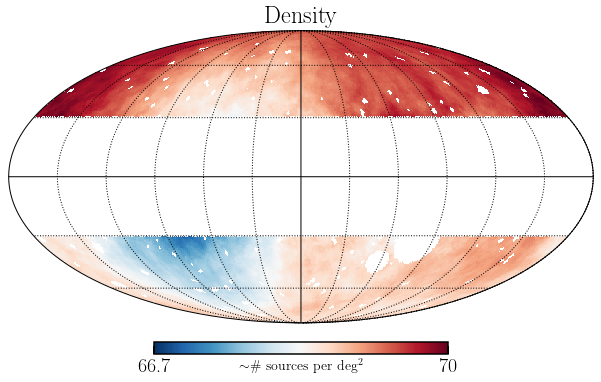

In [24]:
hp.mollview(densitymap_eclcor_smoothed,title='Density',cmap=cm.RdBu_r,badcolor='w',min=66.7,max=70,unit=r'$\sim$\# sources per deg$^2$')
hp.graticule(verbose=False)

# Compute dipole

There are different dipole estimators on the market.  In this publication we chose to go with a least-squares estimator that is part of healpy.

In [26]:
dvec,d = getDipoleVectors_healpy(densitymap_eclcor,mask=lores_mask)
dlon,dlat = vec2dir(dvec)

cat_angdist = angdist(dvec,dir2vec(lon_CMBdipole,lat_CMBdipole))

print('We find the dipole amplitude D={:0.5f} in direction (lon,lat)=({:0.2f},{:0.2f})deg'.format(d,*vec2dir(dvec)))
print('This is {:0.2f}deg away from the CMB dipole direction, and roughly corresponds to a velocity of v={:0.2f}km/s'.format(cat_angdist,dip2vel(d,alpha=np.mean(alpha_w1),x=1.7)/1000.))

We find the dipole amplitude D=0.01554 in direction (lon,lat)=(-121.78,28.80)deg
This is 27.78deg away from the CMB dipole direction, and roughly corresponds to a velocity of v=797.25km/s


The estimate of the dipole velocity is based on the mean value of the spectral indices $\alpha$ and the value of the integrated flux density index $x$ close to the flux density cut, which we measure to be ~1.7.

# Load simulations

Below we list the code with which we ran the simulations.  Since 10,000,000 simulations won't be realistically run within a notebook we first load in the results from the simulations that we saved.

In [27]:
catwise_sims = fits.open('../Data/catwise_3300000sourcesInp_1355352sourcesOut_370kms_10000000sims_CMBdir.fits')[1].data

In [28]:
cat_angdist_sim = angdist(dir2vec(*catwise_sims['lonlats_sim'].transpose()).transpose(),dir2vec(lon_CMBdipole,lat_CMBdipole))

In [29]:
print('In total, {:0.0f} simulations show a larger dipole amplitude than the found value'.format(len(np.where(catwise_sims['d_sim']>d)[0])))

print('The largest dipole of all {:0.0f} simulations is {:0.4f}, compared with the found value {:0.4f}.'.format(len(catwise_sims['d_sim']),np.max(catwise_sims['d_sim']),d))

print('Formally, and (wrongly) assuming a Gaussian, this corresponds to a significance of {:0.3f}sigma'.format((d-np.mean(catwise_sims['d_sim']))/np.std(catwise_sims['d_sim'])))

print('The found dipole amplitude is {:0.3f} times larger than the CMB expectation.'.format(d/np.mean(catwise_sims['d_sim'])))

print('The corresponding p-value is {:0.8f}.'.format(len(catwise_sims['d_sim'][(catwise_sims['d_sim']>d)])/float(len(catwise_sims['d_sim']))))

print('Of those {:0.0f} simulations, {:0.0f} have an angular distance closer to the CMB than what is found for the CatWISE dipole.'.format(len(np.where(catwise_sims['d_sim']>d)[0]),len(catwise_sims['lonlats_sim'][(catwise_sims['d_sim']>d)*(cat_angdist_sim<cat_angdist)])))

print('The corresponding p-value is {:0.8f}.'.format(len(catwise_sims['lonlats_sim'][(catwise_sims['d_sim']>d)*(cat_angdist_sim<cat_angdist)])/float(len(catwise_sims['d_sim']))))

In total, 8 simulations show a larger dipole amplitude than the found value
The largest dipole of all 10000000 simulations is 0.0168, compared with the found value 0.0155.
Formally, and (wrongly) assuming a Gaussian, this corresponds to a significance of 5.408sigma
The found dipole amplitude is 2.082 times larger than the CMB expectation.
The corresponding p-value is 0.00000080.
Of those 8 simulations, 5 have an angular distance closer to the CMB than what is found for the CatWISE dipole.
The corresponding p-value is 0.00000050.


# Plot distributions of simulated dipole amplitudes

/opt/anaconda3/envs/nbk/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  import sys


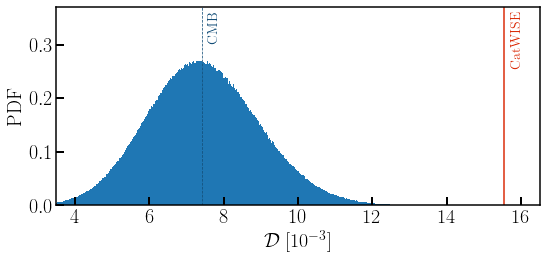

In [30]:
redselect = '#db2c09'
blueselect = '#1f77b4'
blueselect2 = '#144e78'

plt.figure(facecolor='w',figsize=(8,4))

plt.hist(1000*catwise_sims['d_sim'],bins=3000,alpha=1,color=blueselect,normed=True);

plt.axvline(1000*d,color=redselect)
plt.text(1000*d+0.15,.36,r'CatWISE',rotation=90,fontsize=14,color=redselect,horizontalalignment='left',verticalalignment='top')

plt.axvline(1000*np.median(catwise_sims['d_sim']),color=blueselect2,lw=0.75,ls='--')
plt.text(1000*np.median(catwise_sims['d_sim'])+0.15,.36,'CMB',rotation=90,fontsize=14,color=blueselect2,verticalalignment='top')

plt.ylim(0,.37)
plt.xlim(3.5,16.5)
plt.ylabel(r'PDF')
plt.xlabel(r'$\mathcal{D}\;[10^{-3}]$')

plt.tight_layout()

# Plot distributions of simulated dipole directions

While a Fisher distribution would be more appropriate than a Gaussian to measure the 2$\sigma$ contours of the directional distribution, this is only for visualization and has no impact on abovequoted p-values.

In [45]:
cov = np.cov(catwise_sims['lonlats_sim'].transpose())
center = np.mean(catwise_sims['lonlats_sim'].transpose(),axis=1)

lambda1, lambda2 = np.linalg.eig(cov)[0]
theta = np.arctan(np.linalg.eig(cov)[1][1][0]/np.linalg.eig(cov)[1][1][1])

t = np.linspace(0,4*np.pi,num=500)
lonell = np.sqrt(lambda1)*np.cos(theta)*np.cos(t) - np.sqrt(lambda2)*np.sin(theta)*np.sin(t)
latell = np.sqrt(lambda1)*np.sin(theta)*np.cos(t) + np.sqrt(lambda2)*np.cos(theta)*np.sin(t)

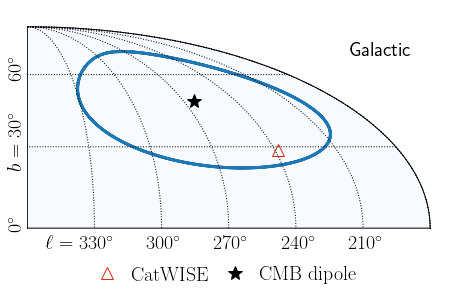

In [46]:
hp.mollview(np.zeros(12),cmap=cm.Blues,min=0,max=1,cbar=None,title='',sub=[1,1,1])
plt.xlim(-.002,2.1)
plt.ylim(-.002,1.1)

factor = 2
hp.projplot(factor*lonell+center[0],factor*latell+center[1],color=blueselect,lw=3,solid_capstyle='butt',alpha=1,lonlat=True)

cq, = hp.projplot(dlon,dlat,'^',markerfacecolor='none',markersize=12,color=redselect,lonlat=True)
cmb, = hp.projplot(lon_CMBdipole,lat_CMBdipole,'*',markersize=15,color='k',lonlat=True,label='CMB dipole')

hp.graticule(verbose=False)

plt.text(0.09,-0.1,r'$\ell=330^\circ$')
plt.text(0.59,-0.1,r'$300^\circ$')
plt.text(0.92,-0.1,r'$270^\circ$')
plt.text(1.26,-0.1,r'$240^\circ$')
plt.text(1.59,-0.1,r'$210^\circ$')

plt.text(-.1,0,r'$0^\circ$',rotation=90)
plt.text(-.1,.3,r'$b=30^\circ$',rotation=90)
plt.text(-.1,.75,r'$60^\circ$',rotation=90)

plt.text(1.6,.86,r'\textsf{Galactic}')

plt.legend([cq,cmb],[r'CatWISE',r'CMB dipole'],bbox_to_anchor=(.46,-.33),loc='lower center',edgecolor='None',handletextpad=0.2,framealpha=0,ncol=2,columnspacing=.3,handler_map={tuple: HandlerTuple(ndivide=None, pad=-.6)})

***

# Run simulations

Above we simply loaded already run simulations.  Here we provide an example of how to run simulations yourself:

In [47]:
W1_fluxcut = 8.52707e-28         # Corresponds to a magnitude of W1<16.4

input_velocity = 369.82*1000     # Input velocity in m/s

N_input = 3.3e6                  # How many sources to begin with
N_output = len(catwiseAGNs)      # How many sources to end up with, after all cuts (as many as the sample has)
N_sim = 30                       # Number of simulations

random_seed = 5000               # Must be an integer, from this an array of random seeds is defined within the loop, 
                                 # such that each simulation is based on a different seed

lonlats_sim_hp = np.zeros((2,N_sim))
lonlats_cor_sim_hp = np.zeros((2,N_sim))
d_sim_hp = np.zeros(N_sim)
N_remaining_sim_hp = np.zeros(N_sim)

t1 = time()

lonlats_sim_hp,_,d_sim_hp,N_remaining_sim_hp = doAll_Vectors_Sim_resampling(N_input,
                                                                                    N_output,
                                                                                    N_sim,
                                                                                    alpha_w1_extended,
                                                                                    flux_w1_extended,
                                                                                    lon_psmask=[lon_LMC,lon_SMC],
                                                                                    lat_psmask=[lat_LMC,lat_SMC],
                                                                                    rad_mask=[rad_LMC,rad_SMC],
                                                                                    galcut=30.,
                                                                                    seed=random_seed,
                                                                                    vel=input_velocity,
                                                                                    do_resampling=True,
                                                                                    estimator='healpy',
                                                                                    masking='onesided',
                                                                                    nside=nside_lo,
                                                                                    W1_fluxcut=W1_fluxcut,
                                                                                    mask=lores_mask)

print('This took ',time()-t1,'seconds')

This took  47.6157660484314 seconds


/opt/anaconda3/envs/nbk/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  import sys


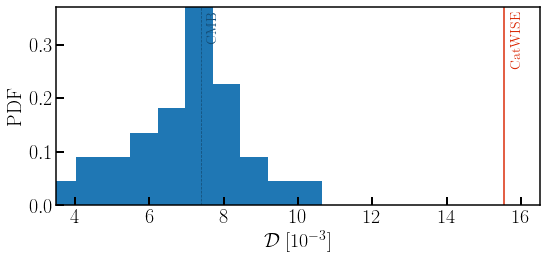

In [163]:
redselect = '#db2c09'
blueselect = '#1f77b4'
blueselect2 = '#144e78'

plt.figure(facecolor='w',figsize=(8,4))

plt.hist(1000*d_sim_hp,bins=10,alpha=1,color=blueselect,normed=True);

plt.axvline(1000*d,color=redselect)
plt.text(1000*d+0.15,.36,r'CatWISE',rotation=90,fontsize=14,color=redselect,horizontalalignment='left',verticalalignment='top')

plt.axvline(1000*np.median(d_sim_hp),color=blueselect2,lw=0.75,ls='--')
plt.text(1000*np.median(d_sim_hp)+0.15,.36,'CMB',rotation=90,fontsize=14,color=blueselect2,verticalalignment='top')

plt.ylim(0,.37)
plt.xlim(3.5,16.5)
plt.ylabel(r'PDF')
plt.xlabel(r'$\mathcal{D}\;[10^{-3}]$')

plt.tight_layout()

***